Name : Kanna Venkata Sai Darsith  
Sub Batch : EE3  
Enrollment No : 23115061  
Topic : Fraud Tranaction Detection In Banks


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

In [4]:
url= '/content/fraud_detection_bank_dataset.csv'
data = pd.read_csv(url)

In [5]:
data.head()

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
0,0,9,1354,0,18,0,1,7,9,0,...,0,0,0,1,1,0,0,0,49,1
1,1,0,239,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,55,1
2,2,0,260,0,4,0,3,6,0,0,...,0,0,0,1,1,0,0,0,56,1
3,3,17,682,0,1,0,0,8,17,0,...,0,1,0,1,1,0,0,0,65,1
4,4,1,540,0,2,0,1,7,1,0,...,0,0,0,1,1,0,0,0,175,1


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display basic information about the dataset
print(data.info())
print(data['targets'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20468 entries, 0 to 20467
Columns: 114 entries, Unnamed: 0 to targets
dtypes: float64(1), int64(113)
memory usage: 17.8 MB
None
targets
0    15030
1     5438
Name: count, dtype: int64


<ipython-input-19-98d3da359273>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='targets', data=data, palette='viridis')


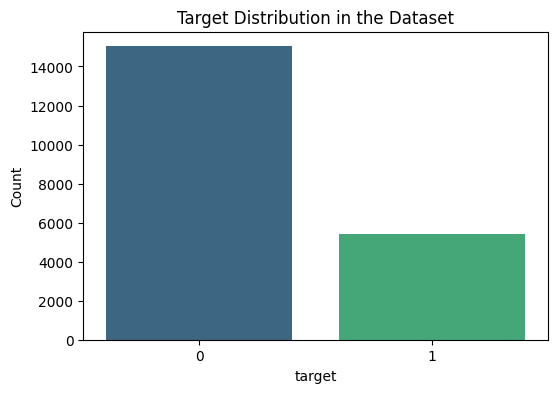

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x='targets', data=data, palette='viridis')
plt.title('Target Distribution in the Dataset')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

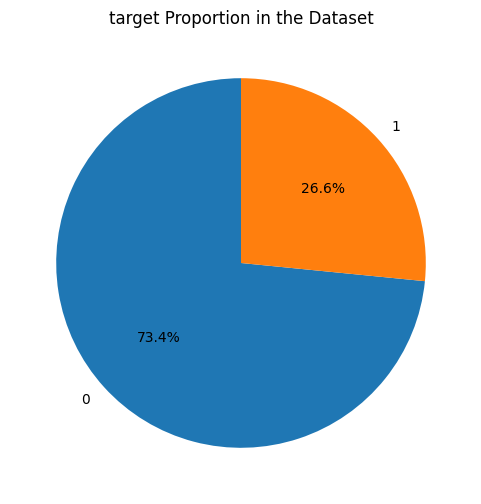

In [20]:
plt.figure(figsize=(6, 6))
class_counts = data['targets'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('target Proportion in the Dataset')
plt.show()

In [10]:
X = data.drop('targets', axis=1)
y = data['targets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# 1. Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns # Apply to X_train

# 2. Create OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for dense output

# 3. Fit and transform the categorical columns in X_train and X_test
# Fit only on training data to avoid data leakage
encoder.fit(X_train[categorical_cols])

X_train_encoded = encoder.transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

# 4. Create DataFrames from the encoded data
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

# 5. Concatenate the encoded DataFrames with the numerical features
X_train_num = X_train.drop(columns=categorical_cols)
X_test_num = X_test.drop(columns=categorical_cols)

X_train = pd.concat([X_train_num, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test_num, X_test_encoded_df],axis=1)

In [12]:
# Random Under Sampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [13]:
# Random Over Sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [14]:
# SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

print(f"Class distribution after SMOTE: {y_smote.value_counts()}")

Class distribution after SMOTE: targets
1    12005
0    12005
Name: count, dtype: int64


targets
0    11990
1     4369
Name: count, dtype: int64


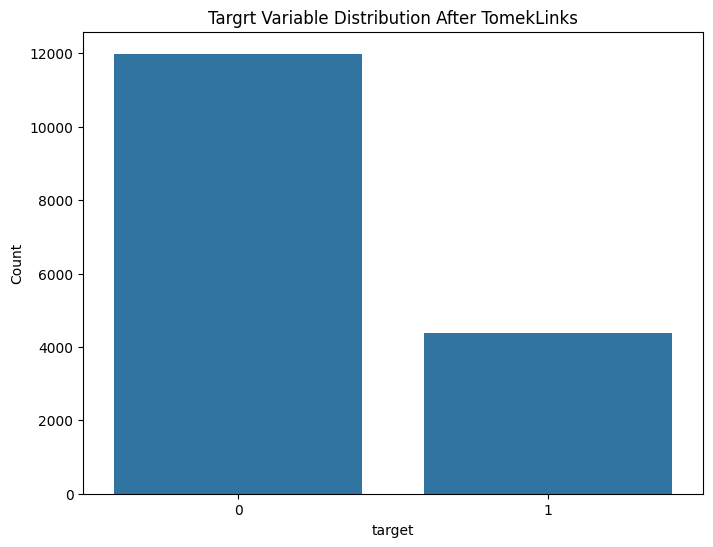

In [21]:
# Tomek Links
tl = TomekLinks()
X_tl, y_tl = tl.fit_resample(X_train, y_train)

print(pd.Series(y_tl).value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_tl)
plt.title('Targrt Variable Distribution After TomekLinks')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

targets
0    12005
1     4369
Name: count, dtype: int64


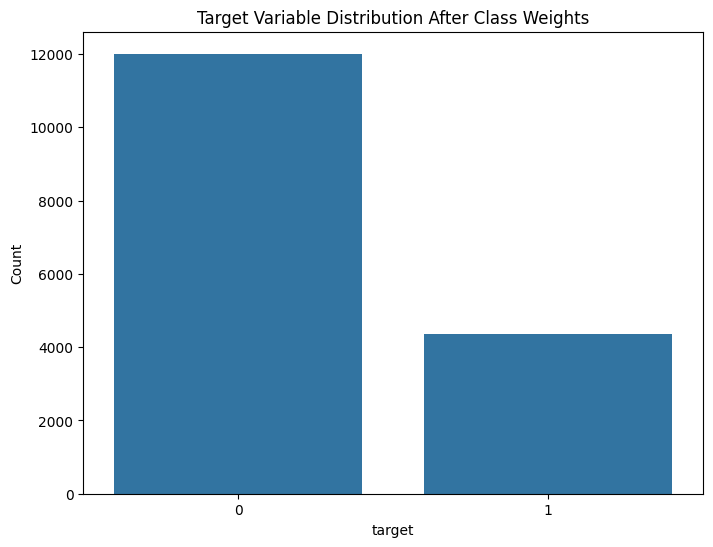

In [22]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

print(pd.Series(y_train).value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title('Target Variable Distribution After Class Weights')
plt.xlabel('target')
plt.ylabel('Count')
plt.show()

In [23]:
# Function to evaluate model performance
def evaluate_model(X_train, y_train, X_test, y_test, class_weights=None):
    model = RandomForestClassifier(class_weight=class_weights, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))

In [24]:
# Evaluate each sampling technique
print("Random Undersampling:")
evaluate_model(X_rus, y_rus, X_test, y_test)

print("\nRandom Oversampling:")
evaluate_model(X_ros, y_ros, X_test, y_test)

print("\nSMOTE:")
evaluate_model(X_smote, y_smote, X_test, y_test)

print("\nTomek Links:")
evaluate_model(X_tl, y_tl, X_test, y_test)

print("\nClass Weights:")
evaluate_model(X_train, y_train, X_test, y_test, class_weights_dict)

Random Undersampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3025
           1       1.00      1.00      1.00      1069

    accuracy                           1.00      4094
   macro avg       1.00      1.00      1.00      4094
weighted avg       1.00      1.00      1.00      4094

AUC: 1.0

Random Oversampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3025
           1       1.00      1.00      1.00      1069

    accuracy                           1.00      4094
   macro avg       1.00      1.00      1.00      4094
weighted avg       1.00      1.00      1.00      4094

AUC: 1.0

SMOTE:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3025
           1       1.00      1.00      1.00      1069

    accuracy                           1.00      4094
   macro avg       1.00      1.00      1.00      4094
weig

Different sampling techniques give the same result and same amount of precission and average for the above data. So all the methods are beneficial for veriying the above data.